In [148]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

### Constante

In [136]:
ua = 149597870700 # m/ua
d = 86400 # s/d
m_sun = 1.9885e30 # kg/m_Sun
G = 6.67430e-11 # m³/kg/s² 
G = G*(86400**2)*m_sun/(ua**3) # ua³/m_Sun/d²
masses2 = np.array([1., 954.79e-6]) # [Sun, Jupiter] in m_Sun
masses = np.array([1., 954.79e-6, 285.87e-6])


### Méthode

In [149]:
def str_to_array(s):
    arr = np.zeros((2,3))
    a = str.split(s,sep='\t')
    arr[0] = a[:3]
    arr[1] = a[3:]
    return arr

def Init_Cond_Cart(N,masses,CM='Sun',*args):
    """
    === Params ===\n
    N :         Number of Body
    masses :    1D array masses [Sun, Jup, Sat,...]
                
    *args :     2D arrays (3,3) of position and velocity
                First axis : coordinates [x, y, z]
                Second axis : velocities [x, y, z]

    === Return ===\n
    pos_init :  1D array of positions [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    mom_init :  1D array of momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    """
    pos_init = np.zeros(N*3)
    mom_init = np.zeros(N*3)

    if CM == 'Sun':
        for i in range(1,N):
            j = i*3
            pos_init[j:j+3] = args[i][0]
            mom_init[j:j+3] = args[i][1]*masses[i]

    elif CM == 'CM':
        R = masses[1]*args[1][0]/(masses[0]+masses[1])
        for i in range(N):
            j = i*3
            pos_init[j:j+3] = args[i][0] - R
            mom_init[j:j+3] = args[i][1]*masses[i] 
        mom_init[0:3] = -mom_init[3:6]
    return pos_init, mom_init

def distance(x1,x2):
    return (np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2+(x1[2]-x2[2])**2))

def dpos_dt(pos,mom,masses):
    N = len(masses)
    dpos = np.zeros_like(pos)
    for i in range(N):
        j = i*3
        dpos[j] = mom[j]/masses[i]
        dpos[j+1] = mom[j+1]/masses[i]
        dpos[j+2] = mom[j+2]/masses[i]
    return dpos

def dmom_dt(pos,mom,masses):
    N = len(masses)
    dmom = np.zeros_like(mom)
    for i in range(N):
        j = i*3
        for k in range(N):
            l = k*3
            if i!=k :
                dmom[j] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j]-pos[l])
                dmom[j+1] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j+1]-pos[l+1])
                dmom[j+2] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j+2]-pos[l+2])
    return dmom

def energy(pos,mom,masses):
    N = len(masses)
    kin = 0
    pot = 0
    for i in range(N):
        j = i*3
        kin += 1/2*np.dot(mom[j:j+3],mom[j:j+3])/masses[i]
        for k in range(i+1,N):
            l = k*3
            pot += G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**2)
    return kin-pot


In [138]:
def Eula(masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    N = int(len(pos_init)/3)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0], mom[:,0],masses)
    for i in range(len(t)-1):
        mom[:,i+1] = mom[:,i] + dt*dmom_dt(pos[:,i],mom[:,i],masses)
        pos[:,i+1] = pos[:,i] + dt*dpos_dt(pos[:,i],mom[:,i],masses)
        E[i+1] = energy(pos[:,i+1], mom[:,i+1],masses) 
    return {'t':t, 'pos':pos, 'mom': mom, 'E':E}

In [139]:
def Heun(masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    N = int(len(pos_init)/3)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0], mom[:,0],masses)
    for i in range(len(t)-1):
        mom_tilde = mom[:,i] + dt*dmom_dt(pos[:,i],mom[:,i],masses)
        pos_tilde = pos[:,i] + dt*dpos_dt(pos[:,i],mom[:,i],masses)

        mom[:,i+1] = mom[:,i] + dt/2*(dmom_dt(pos_tilde,mom_tilde,masses)+dmom_dt(pos[:,i],mom[:,i],masses))
        pos[:,i+1] = pos[:,i] + dt/2*(dpos_dt(pos_tilde,mom_tilde,masses)+dpos_dt(pos[:,i],mom[:,i],masses))
        
        E[i+1] = energy(pos[:,i+1], mom[:,i+1], masses)
    return {'t':t,'pos':pos,'mom':mom,'E':E}

In [140]:
def SV(masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    N = int(len(pos_init)/3)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0],mom[:,0],masses)
    for i in range(len(t)-1):
        mmom = mom[:,i] + dt/2*dmom_dt(pos[:,i],mom[:,i],masses)

        pos[:,i+1] = pos[:,i] + dt*dpos_dt(pos[:,i],mmom,masses)
        
        mom[:,i+1] = mmom + dt/2*dmom_dt(pos[:,i+1],mmom,masses)
        # ppos = pos[:,i] + dt/2*dpos_dt(pos[:,i],mom[:,i],masses)

        # mom[:,i+1] = mom[:,i] + dt*dmom_dt(ppos,mom[:,i],masses)

        # pos[:,i+1] = ppos + dt/2*dpos_dt(ppos,mom[:,i+1],masses)

        E[i+1] = energy(pos[:,i+1],mom[:,i+1],masses)
    return {'t':t,'pos':pos,'mom':mom,'E':E}

### Calculs

In [157]:
# Conditions initiales
N_body = 3
CM = 'CM'
Sun = np.array([[0.,0.,0.],[0.,0.,0.]])
Jup = str_to_array('2.6807183991192	4.2376882009144	-0.0775794762921	-0.0064704852640	0.0043936416864	0.0001265165527')
Sat = str_to_array('9.2153487161163	-3.0079449145055	-0.3144552049022	0.0014174222493	0.0052972607496	-0.0001485973811')
# print(Jup,'\n',Sat)
pos_init, mom_init = Init_Cond_Cart(N_body,masses,CM,Sun,Jup,Sat)
# print(pos_init,'\n',mom_init)

dt = 60 # nbre de jours par dt
N_tmax = 1000 # nbre d'années de la simu
tmax = N_tmax*365 #jours

# solEul = Eula(masses, pos_init, mom_init, dt, tmax)
solHeun = Heun(masses, pos_init, mom_init, dt, tmax)
solSV = SV(masses, pos_init, mom_init, dt, tmax)

# np.savetxt(fname="./Data/Sun_v.txt", X=solHeun['mom'][0:3,:],delimiter=',')
# np.savetxt(fname="./Data/Sun_p.txt", X=solHeun['pos'][0:3,:],delimiter=',')
# np.savetxt(fname="./Data/Jup_v.txt", X=solHeun['mom'][3:6,:],delimiter=',')
# np.savetxt(fname="./Data/Jup_p.txt", X=solHeun['pos'][3:6,:],delimiter=',')
# np.savetxt(fname="./Data/Sat_v.txt", X=solHeun['mom'][6:9,:],delimiter=',')
# np.savetxt(fname="./Data/Sat_p.txt", X=solHeun['pos'][6:9,:],delimiter=',')


### Plot Euler

NameError: name 'solEul' is not defined

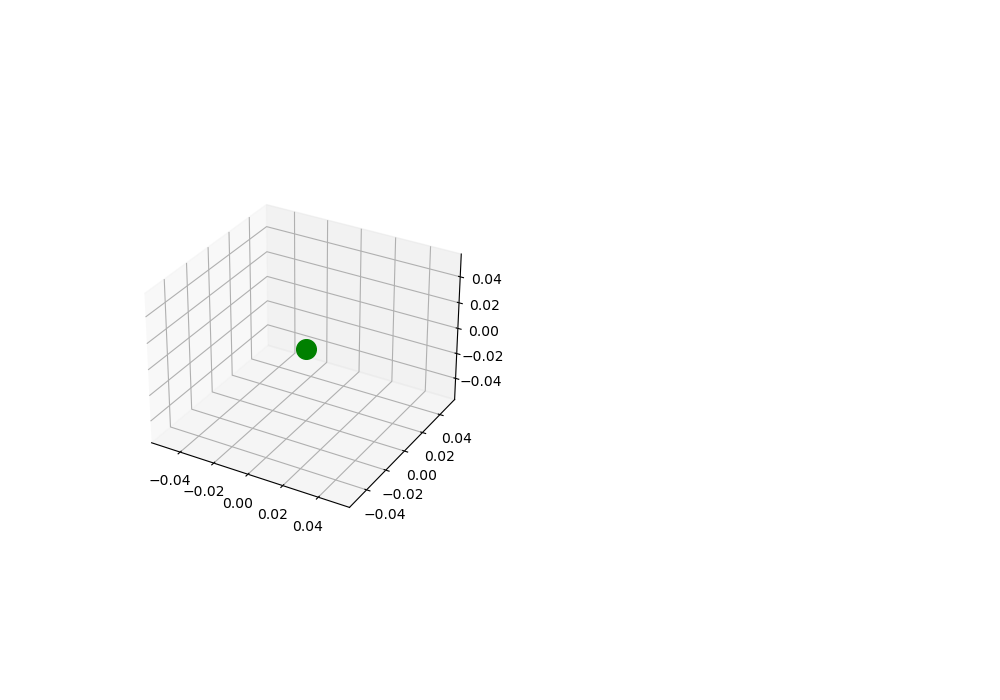

In [9]:
# fig= plt.figure(figsize=(10,7))
# ax1 = fig.add_subplot(1,2,1,projection='3d')
# ax1.scatter(0,0,0,c='green',s=200)
# ax1.plot(solEul['pos'][3,:],solEul['pos'][4,:],solEul['pos'][5,:],c='blue')
# ax1.plot(solEul['pos'][6,:],solEul['pos'][7,:],solEul['pos'][8,:],c='red')
# ax2 = fig.add_subplot(1,2,2)
# ax2.plot(solEul['t'],solEul['E'])

# plt.show()

### Plot Heun

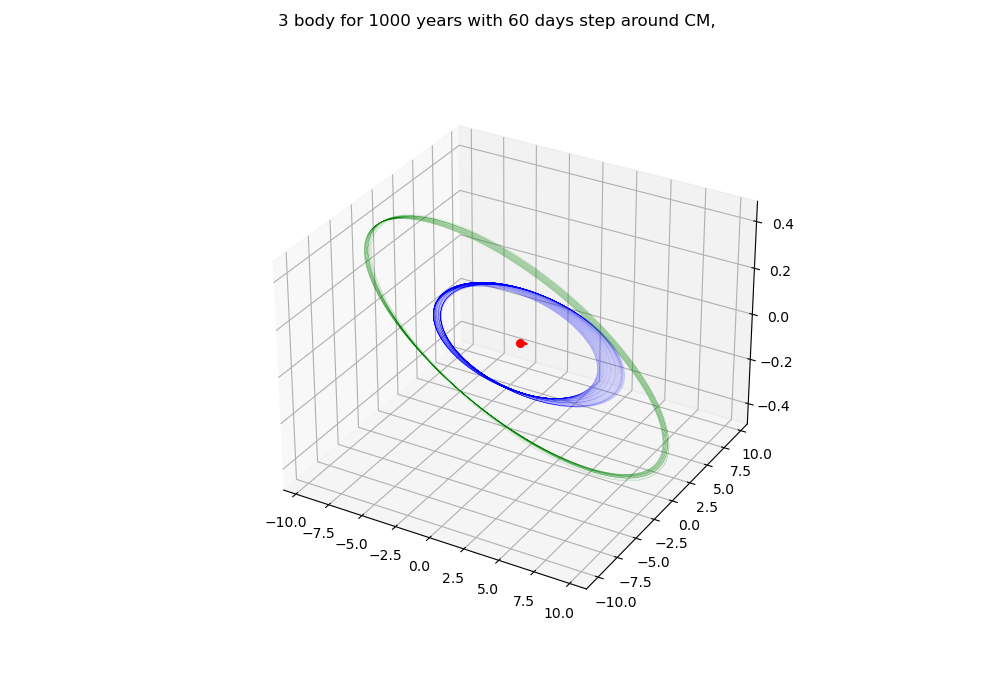

In [161]:
fig= plt.figure(figsize=(10,7))
fig.suptitle('{} body for {} years with {} days step around {} '.format(N_body,N_tmax,dt,CM))
ax1 = fig.add_subplot(1,1,1,projection='3d')
ax1.scatter(solHeun['pos'][0,0],solHeun['pos'][1,0],solHeun['pos'][2,0],c='red',s=30)
ax1.plot(solHeun['pos'][0,:],solHeun['pos'][1,:],solHeun['pos'][2,:],c='red')
ax1.plot(solHeun['pos'][3,:],solHeun['pos'][4,:],solHeun['pos'][5,:],c='blue',linewidth=.05)
ax1.plot(solHeun['pos'][6,:],solHeun['pos'][7,:],solHeun['pos'][8,:],c='green',linewidth=.05)
# ax2 = fig.add_subplot(1,2,2)
# ax2.plot(solHeun['t'],solHeun['E'])

plt.show()

### Plot SV

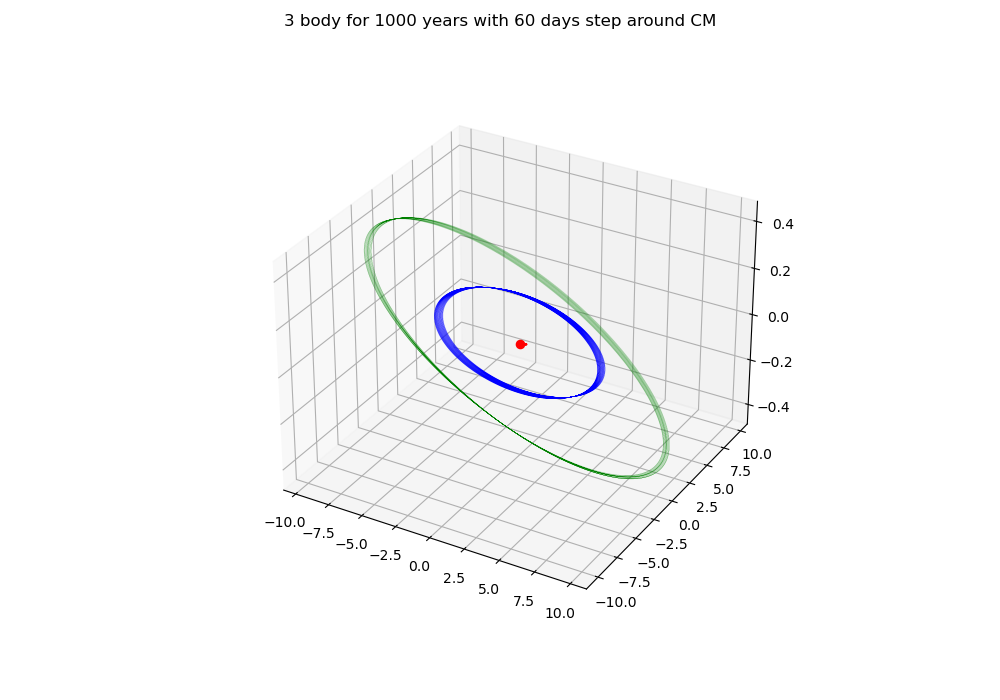

In [162]:
fig= plt.figure(figsize=(10,7))
fig.suptitle('{} body for {} years with {} days step around {}'.format(N_body,N_tmax,dt,CM))
ax1 = fig.add_subplot(1,1,1,projection='3d')
ax1.scatter(solSV['pos'][0,0],solSV['pos'][1,0],solSV['pos'][2,0],c='red',s=35)
ax1.plot(solSV['pos'][0,:],solSV['pos'][1,:],solSV['pos'][2,:],c='red')
ax1.plot(solSV['pos'][3,:],solSV['pos'][4,:],solSV['pos'][5,:],c='blue',linewidth=.05)
ax1.plot(solSV['pos'][6,:],solSV['pos'][7,:],solSV['pos'][8,:],c='green',linewidth=.05)
# ax2 = fig.add_subplot(1,2,2)
# ax2.plot(solSV['t'],solSV['E'])

plt.show()